get data from local database 

successfully connected to database
90065
('# of parcels updated in 2020: ', 108)
('# of parcels updated in 2021: ', 27)
('total # of parcels in table: ', 30094)


,ain,taxratearea,usecode,yearbuilt,effectiveyearbuilt,sqftmain,roll_landvalue,roll_landbaseyear,cluster,situszip5,center_lat,center_lon,landvalue_per_sqft
0,5454027038,4,1100,1994,1994,779,65955.0,1987,27680,90065,34.095796,-118.228163,84.666239
1,6052030026,461,1100,1964,1964,1000,8339.0,1975,26631,90003,33.947870,-118.265508,8.339000
2,4231020033,12463,1100,0,1955,1250,50626.0,1975,25691,90066,33.996590,-118.429746,40.500800
3,5359005001,1797,1100,1961,1961,612,61899.0,1975,27630,91801,34.078510,-118.118021,101.142157
4,4231018015,67,1100,1949,1949,621,31585.0,1975,25691,90066,33.996502,-118.428373,50.861514


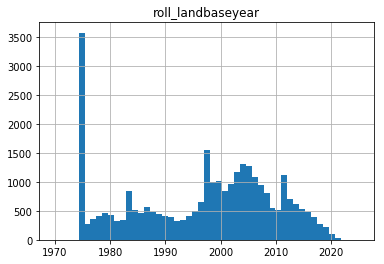

In [67]:
# %%time
import pandas as pd
import psycopg2
import os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# read data from local psql database into pd dataframe
try:
    #conn = psycopg2.connect(database='parcelDatabase', user=os.getenv(
    #    "USER"), password=os.getenv("PASSWORD"))
    conn = psycopg2.connect(database='parceldatabase', user="newuser", password="password")
    print("successfully connected to database")
except:
    print("I am unable to connect to the database")
df = pd.read_sql_query('select * from "svr_table_2"', con=conn)

# print(df.head())
print(df.iloc[0].situszip5)

# taking out irrelevant columns and cols related to building/development on land. Usecode is relevant col but dropping
# b/c we can't parse it rn
# isTaxableParcel is yes for all, so it's not needed here
# usecodedescchar1/usecodedescchar2 are captured by usecode
drop_cols = ['istaxableparcel', 'usecodedescchar1', 'usecodedescchar2']

cat_cols = ['usecode']

df = df.drop(drop_cols, 1)

# convert columns of df to numeric
numeric_cols = ["roll_landbaseyear", "taxratearea", 
                "center_lat", "cluster", "situszip5",
                "center_lon", "roll_landvalue", "sqftmain", 
                "effectiveyearbuilt", "yearbuilt"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

#  add land value per sqft column
df['landvalue_per_sqft'] = df['roll_landvalue'] / df['sqftmain']

# some basic visuals on distr of the land base year
df.hist(column="roll_landbaseyear", range=[1970, 2025], bins=51)

df_updated_2020 = df[df["roll_landbaseyear"] == 2020]
df_updated_2021 = df[df["roll_landbaseyear"] == 2021]

print("# of parcels updated in 2020: ", len(df_updated_2020))
print("# of parcels updated in 2021: ", len(df_updated_2021))
print("total # of parcels in table: ", len(df))
df.head()


In [ ]:
# !pip install sklearn_pandas
# !pip3 install -U sklearn_pandas

based on this reference: https://www.kaggle.com/gauthampughazh/house-sales-price-prediction-svr/notebook

In [42]:
%%time
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from IPython.display import FileLink

CPU times: user 35 µs, sys: 4 µs, total: 39 µs
Wall time: 39.1 µs


In [43]:
# method to turn all characters from usecode to numbers instead of letters
lettersToNumbers = {"A": 10, "B": 11, "C": 12, "D": 13, "E": 14, "F": 15, "G": 16,
                    "H": 17, "I": 18, "J": 19, "K": 20, "L": 21, "M": 22, "N": 23,
                    "O": 24, "P": 25, "Q": 26, "R": 27, "S": 28, "T": 29, "U": 30,
                    "V": 31, "W": 32, "X": 33, "Y": 34, "Z": 35, " ": -1, "*": -2}
def encode(col):
    for x in lettersToNumbers:
        df[col] = df[col].replace(x,lettersToNumbers[x])

In [68]:
# create a new column for each use code character
df['usecode1'] = df['usecode'].astype(str).str[0]
df['usecode2'] = df['usecode'].astype(str).str[1]
df['usecode3'] = df['usecode'].astype(str).str[2]
df['usecode4'] = df['usecode'].astype(str).str[3]

# turn all letters in these new columns into numbers
encode('usecode1')
encode('usecode2')
encode('usecode3')
encode('usecode4')

# turn new cols into numeric values instead of string values
usecode_cols = ['usecode1', 'usecode2', 'usecode3', 'usecode4']
df[usecode_cols] = df[usecode_cols].apply(pd.to_numeric)

# drop use code column since it is now represented by other cols
df = df.drop(['usecode'],1)

In [69]:
# using a smaller sample here - filtering to only properties with a land base year of 2020 or higher
df = df[df['roll_landbaseyear'] > 2018]
print(len(df.index))

349


In [70]:
# remove properties with higher land value
df = df[df['landvalue_per_sqft'] < 3000]
print(len(df.index))

345


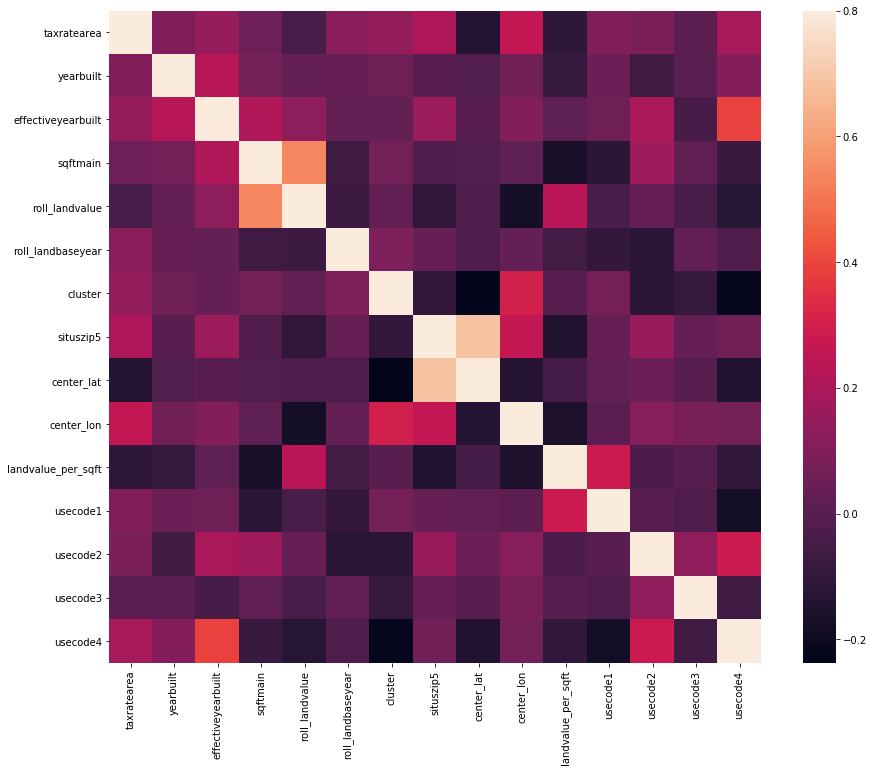

In [71]:

# split data into test and train
train_df, test_df = train_test_split(df, test_size=0.3)

# get correlation matrix
corr_matrix = train_df.corr()
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr_matrix, vmax=0.8, square=True)
plt.show()


In [72]:
#train_df = train_df.drop(['landvalue_per_sqft'], axis=1)
#test_df = test_df.drop(['landvalue_per_sqft'], axis=1)
# Extracting the land value from sample data (what we're trying to find)
#Y_train = train_df['roll_landvalue'].values
#Y_test = test_df['roll_landvalue'].values
#train_df = train_df.drop(['roll_landvalue'], axis=1)
#test_df = test_df.drop(['roll_landvalue'], axis=1)
train_df = train_df.drop(['roll_landvalue'], axis=1)
test_df = test_df.drop(['roll_landvalue'], axis=1)
# Extracting the land value from sample data (what we're trying to find)
Y_train = train_df['landvalue_per_sqft'].values
Y_test = test_df['landvalue_per_sqft'].values
train_df = train_df.drop(['landvalue_per_sqft'], axis=1)
test_df = test_df.drop(['landvalue_per_sqft'], axis=1)

In [73]:
X_train = train_df 
X_test = test_df 

In [74]:
# scaling
# Creating a scaler for input features
X_scaler = MinMaxScaler()

# Transforming the input features of both train and test
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

#transform back to  datafram
X_train = pd.DataFrame(X_train, columns=[
  'ain', 'taxratearea', 'yearbuilt', 'effectiveyearbuilt', 'sqftmain', 'roll_landbaseyear', 'cluster', 'situszip5', 'center_lat',  
  'center_lon', 'usecode1', 'usecode2', 'usecode3', 'usecode4'])
X_test = pd.DataFrame(X_test, columns=[
  'ain', 'taxratearea', 'yearbuilt', 'effectiveyearbuilt', 'sqftmain', 'roll_landbaseyear', 'cluster', 'situszip5', 'center_lat',  
  'center_lon', 'usecode1', 'usecode2', 'usecode3', 'usecode4'])


In [75]:
from sklearn.svm import LinearSVR
svr = LinearSVR(random_state=0, tol=1e-5, max_iter=1000, C=100.0, epsilon=35)
svr.fit(X_train,Y_train)

LinearSVR(C=100.0, dual=True, epsilon=35, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=0, tol=1e-05, verbose=0)

In [76]:
y_pred = svr.predict(X_test)

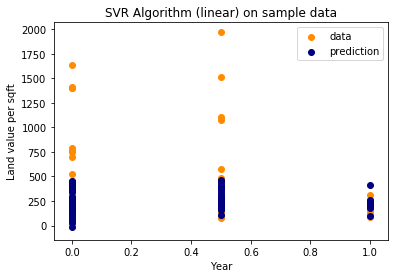

In [77]:
# Evaluate model
plt.scatter(X_test['roll_landbaseyear'], Y_test, color="darkorange", label="data")
plt.scatter(X_test['roll_landbaseyear'], y_pred, color="navy", label="prediction")
plt.legend()
plt.xlabel('Year')
plt.ylabel('Land value per sqft')
plt.title("SVR Algorithm (linear) on sample data")
plt.show()


In [78]:
from math import sqrt
from sklearn.metrics import mean_squared_error
error = sqrt(mean_squared_error(Y_test,y_pred))
error

340.612300116342

In [79]:
models = [AdaBoostRegressor(learning_rate=2),
          LinearSVR(random_state=0, tol=1e-5, max_iter=1000, C=10.0, epsilon=10),
          RandomForestRegressor(n_estimators=200, random_state=1)]
errors = []
for model in models:
    model_name = model.__class__.__name__
    error = np.sqrt(abs(cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error'))).mean()
    errors.append([model_name, error])
    
result_df = pd.DataFrame(errors, columns=['Model name', 'Average error'])

In [80]:
result_df

,Model name,Average error
0,AdaBoostRegressor,380.946217
1,LinearSVR,381.173016
2,RandomForestRegressor,359.655711
